In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TUXML_CSV_FILENAME= "/mnt/temp_dd/igrida-fs1/macher/config_bdd30K.csv" # "./config_bdd.csv" 

# sanity check CSV
with open(TUXML_CSV_FILENAME, "r") as file:
    k = file.readline()
    t = k.split(",")
    s = set(t)
    assert(len(t) == len(s)) # unique number of options/features/column names

# parsing for real with pandas 
rawtuxdata = pd.read_csv(open(TUXML_CSV_FILENAME, "r"))

basic_head = ["cid", "time", "date"] # "compile"
size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]


### basic stats about options and remove of unique values 
## could be improved 

tri_state_values = ['y', 'n', 'm']

ftuniques = []
freq_ymn_features = []
non_tristate_options = []

for col in rawtuxdata:
    ft = rawtuxdata[col]    
    # eg always "y"
    if len(ft.unique()) == 1:
        ftuniques.append(col)
    # only tri-state values (y, n, m) (possible TODO: handle numerical/string options)    
    elif all(x in tri_state_values for x in ft.unique()):     #len(ft.unique()) == 3: 
        freq = ft.value_counts(normalize=True)
        freqy = 0
        freqn = 0
        freqm = 0
        if ('y' in freq.index):
            freqy = freq['y']
        if ('n' in freq.index):
            freqn = freq['n']
        if ('m' in freq.index):
            freqm = freq['m']
        freq_ymn_features.append((col, freqy, freqm, freqn))
    else:
        if not (col in size_methods): 
            non_tristate_options.append(col)
        

### TODO: we want to keep all quantitative values!
# non_tristate_options.remove('LZO') # ('vmlinux')

# we want to keep measurements (that are not tristate ;)) 
# non_tristate_options = list(set(non_tristate_options) - set(size_methods))

#### print options with unique values
# options with only one value eg always "y"
#i = 0
#for ft in ftuniques:
#    print(ft + " (" + str(i) + ")")
#    i = i + 1

print("Original size (#configs/#options) of the dataset " + str(rawtuxdata.shape))
print ("Number of options with only one value (eg always y): " + str(pd.DataFrame(ftuniques).shape))

# maybe we can drop options with only one unique value (no interest for machine learning)
# TODO: maybe we can rely on more traditional feature reduction techniques
# TODO: need to think about *when* to apply the removal 
rawtuxdata.drop(columns=ftuniques,inplace=True) 
## non_tristate_options include basic stuff like date, time, cid but also string/numerical options
print ("Non tri-state value options (eg string or integer or hybrid values): " 
       + str(pd.DataFrame(non_tristate_options).shape) + " ") 
#      + str(pd.DataFrame(non_tristate_options)))


print ("Predictor variables: " + str(rawtuxdata.drop(columns=non_tristate_options).columns.size))
# frequency of y, m, and n values 
#plt.figure()
#pd.DataFrame(freq_ymn_features, columns=["feature", "freqy", "freqm", "freqn"]).plot(kind='hist', alpha=0.8) #plot()
#plt.show()


    



/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1150,2722,6015,6026,6717,7350,7676,7726,10442) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Original size (#configs/#options) of the dataset (30637, 12798)
Number of options with only one value (eg always y): (2903, 1)
Non tri-state value options (eg string or integer or hybrid values): (173, 1) 
Predictor variables: 9722


In [2]:
'X86_64' in ftuniques, 'DEBUG_INFO' in ftuniques, 'GCOV_PROFILE_ALL' in ftuniques, 'KASAN' in ftuniques, 'UBSAN_SANITIZE_ALL' in ftuniques, 'RELOCATABLE' in ftuniques, 'XFS_DEBUG' in ftuniques, 'AIC7XXX_BUILD_FIRMWARE' in ftuniques, 'AIC79XX_BUILD_FIRMWARE' in ftuniques, 'WANXL_BUILD_FIRMWARE' in ftuniques

(False, False, False, False, False, False, False, False, False, False)

In [3]:
if 'RELOCATABLE' in rawtuxdata.columns:
    print(rawtuxdata.query("RELOCATABLE == 'y'")[['cid', 'RELOCATABLE']], rawtuxdata.query("RELOCATABLE == 'y'").shape)

         cid RELOCATABLE
0      62000           y
1      62001           y
2      62002           y
3      62003           y
6      62006           y
7      62007           y
8      62008           y
9      62009           y
10     62010           y
12     62012           y
13     62013           y
14     62014           y
15     62015           y
17     62017           y
18     62018           y
19     62019           y
20     62020           y
21     62021           y
23     62023           y
25     62025           y
27     62027           y
32     62032           y
36     62036           y
38     62038           y
39     62039           y
40     62040           y
42     62042           y
44     62044           y
45     62045           y
46     62046           y
...      ...         ...
30355  92518           y
30366  92529           y
30371  92534           y
30382  92545           y
30400  92563           y
30402  92565           y
30418  92581           y
30423  92586           y


In [4]:
print("Data exploration")

Data exploration


In [5]:
# BUGS EXPLORATION
def bug_exploration():
    rawtuxdata.query("AIC7XXX_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("AIC79XX_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("WANXL_BUILD_FIRMWARE == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'n' & DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'y' & DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]
    rawtuxdata.query("GENERIC_ALLOCATOR == 'n' & DRM_VBOXVIDEO == 'm'")[['cid', 'vmlinux']]
    return rawtuxdata.query("DRM_VBOXVIDEO == 'y'")[['cid', 'vmlinux']]

bug_exploration()





,cid,vmlinux
3,62003,87309464
19,62019,-1
20,62020,50004688
36,62036,325498712
70,62070,-1
85,62085,65814400
88,62088,40872248
91,62091,63463480
117,62117,43351072
121,62121,78769944


In [6]:
#rawtuxdata[rawtuxdata['X86_64'] == 'n']
#rawtuxdata.query("X86_64 == 'n'")

In [7]:
#rawtuxdata[(rawtuxdata['DEBUG_INFO'] == 'n') & (rawtuxdata['GCOV_PROFILE_ALL'] == 'n') & (rawtuxdata['KASAN'] == 'n') & (rawtuxdata['MODULES'] == 'y')]
# rawtuxdata.query("(DEBUG_INFO == 'n') & (GCOV_PROFILE_ALL == 'n') & (KASAN == 'n') & (MODULES == 'y')")
#rawtuxdata.query("(DEBUG_INFO == 'n') & (GCOV_PROFILE_ALL == 'n') & (KASAN == 'n')").shape, rawtuxdata.shape


In [8]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072][['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']]
tiny_data = rawtuxdata.query("vmlinux == 1168072") #tiny config for X86_32
#if (len(tiny_data) > 0):
#    print(tiny_data[['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']])

In [9]:
#rawtuxdata[rawtuxdata['vmlinux'] == -1]
rawtuxdata.query("vmlinux == -1")

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,ARCH_SUPPORTS_INT128,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS
12,62012,2018-06-27 08:53:58,650.557,-1,-1,-1,-1,-1,-1,-1,...,y,y,y,y,n,n,y,y,y,n
19,62019,2018-06-27 08:55:15,803.271,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,y,y,n,n,n,n,y
25,62025,2018-06-27 08:56:52,204.002,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,y,n,n,n,n,n,n
69,62069,2018-06-27 09:04:39,616.790,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,y,n,n,y,n,n,n
70,62070,2018-06-27 09:04:38,522.449,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,n,n,n,y,n,y,y
93,62093,2018-06-27 09:09:30,604.755,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,y,n,n,y,n,n,n
146,62146,2018-06-27 09:18:33,625.524,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,y,n,n,y,n,n,n
169,62169,2018-06-27 09:21:46,461.916,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,n,n,n,n,n,y,n
187,62187,2018-06-27 09:25:04,362.615,-1,-1,-1,-1,-1,-1,-1,...,n,y,y,n,y,n,n,n,y,y
214,62214,2018-06-27 09:30:04,573.729,-1,-1,-1,-1,-1,-1,-1,...,n,n,y,y,n,n,n,n,y,n


In [10]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072]['MODULES']
rawtuxdata.query("vmlinux == 1168072")['MODULES'] #tiny config for X86_32

8604     n
8608     n
8617     n
8618     n
24554    n
Name: MODULES, dtype: object

In [11]:
# playing a bit with the data 
rawtuxdata.dtypes
# 'DEBUG_INFOO' in list(pd.DataFrame(non_tristate_options)[0]) # 
# tuxdata['DEBUG_INFO'].unique()
#tuxdata['OUTPUT_FORMAT'].dtypes
#tuxdata['DEFAULT_HOSTNAME'].unique()

#rawtuxdata[:5]
rawtuxdata[:20]['vmlinux']
#tuxdata[:5]['CONFIG_DEBUG_INFO']
#tuxdata['ARCH_HAS_SG_CHAIN'].unique()
#tuxdata['ARCH_HAS_SG_CHAIN'].astype('category')

0      55559344
1      37436552
2      68465904
3      87309464
4      35289888
5      25067464
6      33254424
7      33917232
8      34379048
9     168606904
10    304245920
11     24167768
12           -1
13     53676608
14     67717688
15     22804840
16     47719480
17     13585048
18     74078032
19           -1
Name: vmlinux, dtype: int64

In [12]:
rawtuxdata.shape, rawtuxdata.query("vmlinux != -1").shape

((30637, 9895), (29130, 9895))

In [13]:
print("some configurations may have X86_32 (coz we have tested/tried some options and there are in the database)")
# we only keep X86_64 configurations
#rawtuxdata = rawtuxdata[rawtuxdata['X86_64'] == 'y'] ### TODO: I've impression it's not the most effective way (wrt memory) to filter 
if 'X86_64' in rawtuxdata.columns:
    print(rawtuxdata['X86_64'].describe())
    rawtuxdata.query("X86_64 == 'y'", inplace=True)
rawtuxdata.info(memory_usage='deep')

some configurations may have X86_32 (coz we have tested/tried some options and there are in the database)
count     30637
unique        2
top           y
freq      30607
Name: X86_64, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30607 entries, 0 to 30636
Columns: 9895 entries, cid to NETWORK_FILESYSTEMS
dtypes: float64(1), int64(153), object(9741)
memory usage: 18.3 GB


In [14]:
from sklearn.preprocessing import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import tree
import graphviz 


LEARN_COMPILATION_SUCCESS = True # costly in time and space 
compilation_status_column_name = 'compile_success'

def encode_data_compilation(rawtuxdata):
    lae = LabelEncoder()
    # we save quantitative values we want (here vmlinux, TODO: generalize)
    # the key idea is that the labelling encoder should not be applied to this kind of values (only to predictor variables!)
    # vml = rawtuxdata['LZO'] # rawtuxdata['vmlinux'] 
    o_sizes = rawtuxdata[size_methods]

    # we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
    #tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
    tuxdata_for_compilation = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(lae.fit_transform)

    #tuxdata['vmlinux'] = vml 
    tuxdata_for_compilation[size_methods] = o_sizes
    # we can ue vmlinux since it has been restored thanks to previous line
    tuxdata_for_compilation[compilation_status_column_name] = tuxdata_for_compilation['vmlinux'] != -1
    return tuxdata_for_compilation

def learn_compilation_success(tuxdata_for_compilation):
    TESTING_SIZE=0.3 
    X_train, X_test, y_train, y_test = train_test_split(tuxdata_for_compilation.drop(columns=size_methods).drop(columns=compilation_status_column_name), tuxdata_for_compilation[compilation_status_column_name], test_size=TESTING_SIZE, random_state=0)  
    clf = tree.DecisionTreeClassifier() #GradientBoostingClassifier(n_estimators=100) #RandomForestRegressor(n_estimators=100) #   #GradientBoostingRegressor(n_estimators=100)  
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]    

    TOP_FT_IMPORTANCE=20
    print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
    for f in range(TOP_FT_IMPORTANCE): # len(indices)
        print("%d. feature %s %d (%f)" % (f + 1, tuxdata_for_compilation.columns[indices[f]], indices[f], importances[indices[f]]))
   
    
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=tuxdata_for_compilation.drop(columns=size_methods).drop(columns=compilation_status_column_name).columns,  
                         filled=True, rounded=True,
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render("TUXML compilation sucess")
    
    acc = accuracy_score (y_test, y_pred)
    prec = precision_score (y_test, y_pred)
    reca = recall_score (y_test, y_pred)
    f1 = f1_score (y_test, y_pred)
    print("Accuracy score: %.2f" % (acc))
    print("Precision score: %.2f" % (prec))
    print("Recall score: %.2f" % (reca))
    print("F1 score: %.2f" % (f1))

if (LEARN_COMPILATION_SUCCESS):
    tuxdata_for_compilation = encode_data_compilation(rawtuxdata)
    tuxdata_for_compilation [compilation_status_column_name].describe()
    learn_compilation_success(tuxdata_for_compilation)
    del tuxdata_for_compilation

Feature ranking: top (20)
1. feature AIC79XX_BUILD_FIRMWARE 2021 (0.456438)
2. feature AIC7XXX_BUILD_FIRMWARE 1435 (0.305829)
3. feature WANXL_BUILD_FIRMWARE 8143 (0.100780)
4. feature DRM_VBOXVIDEO 6181 (0.087736)
5. feature GENERIC_ALLOCATOR 9197 (0.008125)
6. feature CRC32_SLICEBY8 6752 (0.003519)
7. feature TEST_STRING_HELPERS 849 (0.002835)
8. feature SND_SOC_IMG_I2S_OUT 8433 (0.002660)
9. feature FB_ATY_GENERIC_LCD 4896 (0.002282)
10. feature INFINIBAND_ADDR_TRANS 4868 (0.002252)
11. feature TOUCHSCREEN_MELFAS_MIP4 352 (0.001993)
12. feature INPUT_LEDS 3293 (0.001869)
13. feature FB_CFB_COPYAREA 5523 (0.001794)
14. feature DEBUG_INFO 4388 (0.001424)
15. feature ENABLE_DEFAULT_TRACERS 9271 (0.000994)
16. feature IGB_DCA 5424 (0.000986)
17. feature PWRSEQ_SD8787 472 (0.000986)
18. feature MTD_MT81xx_NOR 239 (0.000983)
19. feature BT_HCIUART_NOKIA 6267 (0.000980)
20. feature SND_SOC_INTEL_SST_FIRMWARE 8708 (0.000976)
Accuracy score: 1.00
Precision score: 1.00
Recall score: 1.00
F1 s

In [15]:
#rawtuxdata.query("vmlinux == -1")[['cid', 'AIC7XXX_BUILD_FIRMWARE', 'AIC79XX_BUILD_FIRMWARE', 'IPVTAP', 'WANXL_BUILD_FIRMWARE', 'TCIC']]


In [16]:
# aka MAPE
def mean_relative_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [17]:
# remove entries with same configurations
print(str(len(rawtuxdata)) + " before the removal of some entries (those with same configurations)")
# tuxdata.drop_duplicates(subset=tuxdata.columns.difference(['vmlinux']), inplace=True)
rawtuxdata.drop_duplicates(subset=rawtuxdata.columns.difference(size_methods).difference(basic_head), inplace=True)
print(str(len(rawtuxdata)) + " after the removal of some entries (those with same configurations)")

#n_failures = len(tuxdata[~np.isnan(tuxdata['vmlinux'])])
#n_failures = len(rawtuxdata.query("vmlinux != -1")) #len(tuxdata[np.isnan(tuxdata['vmlinux'])])
#print(str(n_failures) + " non-failures out of " + str(len(rawtuxdata)))

#tuxdata = tuxdata[~np.isnan(tuxdata['vmlinux'])]
#rawtuxdata = rawtuxdata[rawtuxdata['vmlinux'] != -1] #tuxdata[~np.isnan(tuxdata['vmlinux'])]
rawtuxdata.query("(vmlinux != -1) & (vmlinux != 0)", inplace=True)
print(str(len(rawtuxdata)) + " after the removal of configurations that do NOT compile")


30607 before the removal of some entries (those with same configurations)
30589 after the removal of some entries (those with same configurations)
29098 after the removal of configurations that do NOT compile


In [18]:
rawtuxdata.query("vmlinux == 1168072") # tinyconfig with X86_32

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,ARCH_SUPPORTS_INT128,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS


In [19]:
rawtuxdata.query("vmlinux == 7317008") # tiny config for X86_64

,cid,date,time,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,...,SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH,APDS9960,ARCH_SUPPORTS_INT128,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS
12299,74458,2018-07-05 16:07:21,28.7108,7317008,646608,2733176,501222,4722128,6808144,458568,...,n,n,y,n,n,n,n,n,n,n


<Figure size 432x288 with 0 Axes>

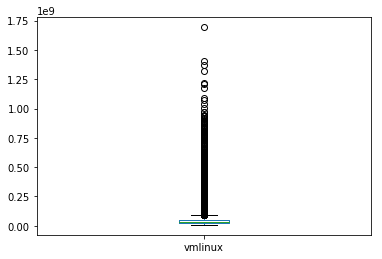

<Figure size 432x288 with 0 Axes>

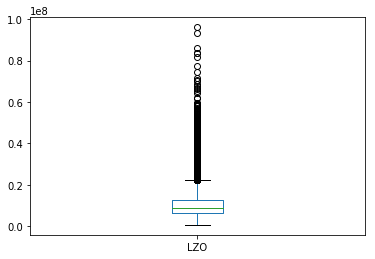

<Figure size 432x288 with 0 Axes>

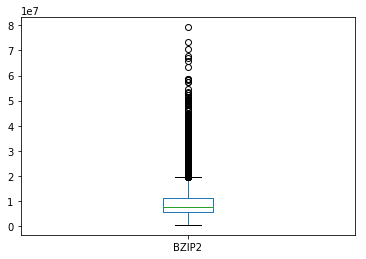

count    2.909800e+04
mean     5.146904e+07
std      6.787058e+07
min      7.317008e+06
25%      2.410287e+07
50%      3.378448e+07
75%      5.126702e+07
max      1.693674e+09
Name: vmlinux, dtype: float64

In [20]:
plt.figure()
pd.DataFrame(rawtuxdata['vmlinux']).plot.box()
plt.show(block=False)

plt.figure()
pd.DataFrame(rawtuxdata['LZO']).plot.box()
plt.show(block=False)

plt.figure()
pd.DataFrame(rawtuxdata['BZIP2']).plot.box()
plt.show(block=False)


rawtuxdata['vmlinux'].describe()


In [21]:
import scipy.stats
import seaborn as sns



def color_negative_positive(val, pcolor="green", ncolor="red"):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = pcolor if val > 0 else ncolor 
    if val == 0:
        color = 'black' 
    return 'color: %s' % color

compress_methods = ["GZIP", "BZIP2", "LZMA", "XZ", "LZO", "LZ4"]
def compareCompress(size_measure_of_interest): #"" # "-vmlinux" #"-bzImage" # prefix
    rCompressDiff = pd.DataFrame(index=list(map(lambda c: c + "o", compress_methods)) , columns=compress_methods) 
    for compress_method in compress_methods:
        for compress_method2 in compress_methods:
            rCompressDiff.loc[compress_method + "o"][compress_method2] = (np.mean(rawtuxdata[compress_method + size_measure_of_interest] / rawtuxdata[compress_method2 + size_measure_of_interest]) * 100) - 100
    return rCompressDiff

#cmy = sns.light_palette("red", as_cmap=True)
compareCompress("").style.set_caption('Difference (average in percentage) per compression methods').applymap(color_negative_positive)

,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,3.00409,24.1075,37.5807,-9.84647,-37771.6
BZIP2o,-2.85938,0,20.5629,33.6321,-12.4552,-36319.8
LZMAo,-19.3674,-16.9444,0,10.8618,-27.2786,-29692.8
XZo,-27.0015,-24.8181,-9.46493,0,-34.1699,-27520.5
LZOo,10.9803,14.2732,37.7969,52.7391,0,-41972.2
LZ4o,18.834,22.3366,47.584,63.5921,7.04909,0


In [22]:
compareCompress("-bzImage").style.set_caption('Difference (average in percentage) per compression methods, bzImage').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-32.7688,23.7047,36.554,-9.51477,-15.4669
BZIP2o,53.1827,0,88.9821,108.159,38.7021,29.6217
LZMAo,-19.1039,-45.7586,0,10.3884,-26.772,-31.5763
XZo,-26.4578,-50.7791,-9.09136,0,-33.4336,-37.7988
LZOo,10.5725,-25.6061,36.8458,51.047,0,-6.59913
LZ4o,18.4297,-20.2875,46.6039,61.822,7.07913,0


In [23]:
compareCompress("-vmlinux").style.set_caption('Difference (average in percentage) per compression methods, vmlinux').applymap(color_negative_positive)


,GZIP,BZIP2,LZMA,XZ,LZO,LZ4
GZIPo,0,-27.4404,17.9974,27.0732,-7.67451,-12.6286
BZIP2o,39.6672,0,64.2376,76.5538,29.1064,22.2699
LZMAo,-15.147,-38.6417,0,7.65599,-21.613,-25.7954
XZo,-20.988,-42.9628,-6.91522,0,-27.0016,-30.889
LZOo,8.36892,-21.2692,27.957,37.8114,0,-5.38986
LZ4o,14.5917,-16.683,35.356,45.7952,5.71283,0


In [24]:
cm = sns.light_palette("green", as_cmap=True)
pd.DataFrame.corr(rawtuxdata[size_methods]).style.set_caption('Correlations between size measures').background_gradient(cmap=cm)


,vmlinux,GZIP-bzImage,GZIP-vmlinux,GZIP,BZIP2-bzImage,BZIP2-vmlinux,BZIP2,LZMA-bzImage,LZMA-vmlinux,LZMA,XZ-bzImage,XZ-vmlinux,XZ,LZO-bzImage,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4
vmlinux,1,0.525318,0.525345,0.52439,0.538594,0.538442,0.537736,0.509452,0.50949,0.508168,0.512384,0.512425,0.51101,0.543367,0.543389,0.542644,0.550595,0.550614,0.549945
GZIP-bzImage,0.525318,1,1,0.99999,0.997491,0.996936,0.997652,0.997609,0.997611,0.997529,0.993304,0.993305,0.993217,0.997206,0.997202,0.997327,0.994154,0.994149,0.994253
GZIP-vmlinux,0.525345,1,1,0.999989,0.997496,0.996941,0.997657,0.997608,0.997609,0.997527,0.993303,0.993305,0.993215,0.99721,0.997207,0.997331,0.99416,0.994155,0.994259
GZIP,0.52439,0.99999,0.999989,1,0.997311,0.996755,0.997493,0.997642,0.997643,0.99759,0.99333,0.993331,0.993273,0.997044,0.997039,0.997182,0.993925,0.99392,0.99404
BZIP2-bzImage,0.538594,0.997491,0.997496,0.997311,1,0.999446,0.999989,0.994214,0.994222,0.993907,0.990641,0.990649,0.99031,0.998421,0.998422,0.998397,0.997187,0.997186,0.997155
BZIP2-vmlinux,0.538442,0.996936,0.996941,0.996755,0.999446,1,0.999435,0.993656,0.993665,0.993349,0.990052,0.99006,0.98972,0.997878,0.997879,0.997853,0.996649,0.996648,0.996617
BZIP2,0.537736,0.997652,0.997657,0.997493,0.999989,0.999435,1,0.994418,0.994426,0.99414,0.990839,0.990847,0.990539,0.998428,0.998427,0.998421,0.997126,0.997124,0.997111
LZMA-bzImage,0.509452,0.997609,0.997608,0.997642,0.994214,0.993656,0.994418,1,1,0.999982,0.993553,0.993553,0.993531,0.990992,0.990987,0.991147,0.986189,0.986184,0.98632
LZMA-vmlinux,0.50949,0.997611,0.997609,0.997643,0.994222,0.993665,0.994426,1,1,0.99998,0.993554,0.993554,0.99353,0.991,0.990995,0.991154,0.9862,0.986194,0.986329
LZMA,0.508168,0.997529,0.997527,0.99759,0.993907,0.993349,0.99414,0.999982,0.99998,1,0.993526,0.993524,0.993543,0.990707,0.990701,0.990886,0.985815,0.985808,0.985966


In [25]:
#from category_encoders import *
from sklearn.preprocessing import *

## class to integer encoding (y, n, m)

## note: we also remove non-tristate-options
# "in place" is to avoid memory burden (having two dfs in memory)

# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()
# 2/3. FIT AND TRANSFORM
vml = rawtuxdata[size_methods]

# we remove non tri state options, but TODO there are perhaps some interesting options (numerical or string) here
#tuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=['vmlinux']).apply(le.fit_transform)
rawtuxdata = rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(le.fit_transform)

#tuxdata['vmlinux'] = vml 
rawtuxdata[size_methods] = vml
 
rawtuxdata.shape, rawtuxdata.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29098 entries, 0 to 30636
Columns: 9722 entries, X86_LOCAL_APIC to LZ4
dtypes: int64(9722)
memory usage: 2.1 GB


((29098, 9722), None)

In [26]:
#### takes a while
# One-Hot-Encoding 
#from sklearn.preprocessing import *

#enc = OneHotEncoder()
#o_sizes = rawtuxdata[size_methods]
#oh_tuxdata = enc.fit_transform(rawtuxdata)
#oh_tuxdata.shape, o_sizes.shape
# rawtuxdata.drop(columns=non_tristate_options).drop(columns=size_methods).apply(enc.fit_transform)
#oh_tuxdata[size_methods] = o_sizes

In [27]:
# DUMMY (with Pandas)

#o_sizes = tuxdata[size_methods]
#tuxdata_dummy = pd.get_dummies(rawtuxdata.drop(columns=size_methods), columns=rawtuxdata.drop(columns=size_methods).columns)
#tuxdata_dummy[size_methods] = o_sizes
#tuxdata_dummy.shape

In [28]:
# Data exploration (again)
#print(rawtuxdata['UBSAN_SANITIZE_ALL'].value_counts(), rawtuxdata['COMPILE_TEST'].value_counts(), rawtuxdata['NOHIGHMEM'].value_counts(), rawtuxdata['OPTIMIZE_INLINING'].value_counts(), rawtuxdata['SLOB'].value_counts(), rawtuxdata['CC_OPTIMIZE_FOR_SIZE'].value_counts(), sep='\n')

In [29]:
from enum import Enum
class LearningStrategy(Enum):
    LINEAR = 1
    AUTOML = 2
    ML = 3

In [30]:
from sklearn.pipeline import Pipeline

# https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
class PipelineRFE(Pipeline):

    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

In [31]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import svm
from sklearn.decomposition import PCA
from tpot import TPOTRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.neural_network import MLPRegressor





# drop(columns=["date", "time", "vmlinux", "cid"])
# tuxdata.drop(columns=non_tristate_options)

NO_ENCODED_VALUE = le.transform(['n'])[0] 

def mkNoOption(option_name):
    return "(" + option_name + " == " + str(NO_ENCODED_VALUE) + ")"

def prefilter_data(tuxdata):    
    return rawtuxdata
    #return rawtuxdata.query(mkNoOption("DEBUG_INFO"))
    #return rawtuxdata.query(mkNoOption("DEBUG_INFO") + " & " + mkNoOption("GCOV_PROFILE_ALL") + " & " + mkNoOption("KASAN") + " & " + mkNoOption("UBSAN_SANITIZE_ALL") + " & " + mkNoOption("RELOCATABLE") + " & " + mkNoOption("XFS_DEBUG"))
                

def regLearning(tuxdata, kindOfLearning=LearningStrategy.ML):
 
    TESTING_SIZE=0.9 # 0.9 means 10% for training, 90% for testing
    size_of_interest = "vmlinux" # could be LZO, BZIP, etc. 
    PRINT_FEATURE_IMPORTANCES = True
   
       
    #X_train, X_test, y_train, y_test = train_test_split(tuxdata[(tuxdata['DEBUG_INFO'] == le.transform(['n'])[0])].drop(columns=size_methods), tuxdata[(tuxdata['DEBUG_INFO'] == le.transform(['n'])[0])][size_of_interest], test_size=TESTING_SIZE, random_state=0)  
    print ("Warning: prefiltering on DEBUG_INFO=n GCOV_PROFILE_ALL=n KASAN=n ....")   
    X_train, X_test, y_train, y_test = train_test_split(prefilter_data(tuxdata).drop(columns=size_methods), prefilter_data(tuxdata)[size_of_interest], test_size=TESTING_SIZE, random_state=0)  
  
    # multi output
    #X_train, X_test, y_train, y_test = train_test_split(tuxdata.drop(columns=size_methods), tuxdata[size_methods], test_size=TESTING_SIZE, random_state=0)  

    # train_test_split(tuxdata.drop(columns=['vmlinux']), tuxdata['vmlinux'], test_size=TESTING_SIZE, random_state=0)  

    #clf = RandomForestRegressor(n_estimators=100) 

    if kindOfLearning == LearningStrategy.LINEAR:
        regr =  linear_model.Lasso() # svm.SVC(kernel='linear') # linear_model.Ridge(alpha=.1) #  # linear_model.Lasso() # linear_model.SGDRegressor() #LinearRegression() # SGDRegressor or linear_model.Lasso()
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)

    elif kindOfLearning == LearningStrategy.AUTOML:


        tpot_config = {

            'sklearn.linear_model.ElasticNetCV': {
                'l1_ratio': np.arange(0.0, 1.01, 0.05),
                'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
            },

            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'bootstrap': [True, False]
            },

            'sklearn.ensemble.GradientBoostingRegressor': {
                'n_estimators': [100],
                'loss': ["ls", "lad", "huber", "quantile"],
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'max_depth': range(1, 11),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'subsample': np.arange(0.05, 1.01, 0.05),
                'max_features': np.arange(0.05, 1.01, 0.05),
                'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
            },

            'sklearn.ensemble.AdaBoostRegressor': {
                'n_estimators': [100],
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'loss': ["linear", "square", "exponential"],
                'max_depth': range(1, 11)
            },

            'sklearn.tree.DecisionTreeRegressor': {
                'max_depth': range(1, 11),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21)
            },

            'sklearn.neighbors.KNeighborsRegressor': {
                'n_neighbors': range(1, 101),
                'weights': ["uniform", "distance"],
                'p': [1, 2]
            },

            'sklearn.linear_model.LassoLarsCV': {
                'normalize': [True, False]
            },

            'sklearn.svm.LinearSVR': {
                'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
                'dual': [True, False],
                'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
                'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
            },

            'sklearn.ensemble.RandomForestRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05),
                'min_samples_split': range(2, 21),
                'min_samples_leaf': range(1, 21),
                'bootstrap': [True, False]
            },

            'sklearn.linear_model.RidgeCV': {
            },

            'xgboost.XGBRegressor': {
                'n_estimators': [100],
                'max_depth': range(1, 11),
                'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
                'subsample': np.arange(0.05, 1.01, 0.05),
                'min_child_weight': range(1, 21),
                'nthread': [1]
            }     
        }

        tpot = TPOTRegressor(generations=5, population_size=50, verbosity=3, config_dict=tpot_config, scoring='neg_mean_absolute_error')
        tpot.fit(X_train, y_train)
        y_pred = tpot.predict(X_test)
        print(tpot.score(X_test, y_test))
        print(tpot.evaluated_individuals_)
        tpot.export('tpot_boston_pipeline.py')

    else:
        assert (kindOfLearning == LearningStrategy.ML)
        clf = GradientBoostingRegressor(n_estimators=100) #RandomForestRegressor(n_estimators=100) #GradientBoostingRegressor(n_estimators=100) # KNeighborsRegressor() #RandomForestRegressor(n_estimators=100) # linear_model.SGDRegressor(alpha=0.15, max_iter=200)
        # #LassoLarsCV() # MLPRegressor() # GradientBoostingRegressor(n_estimators=100) # ExtraTreesRegressor(n_estimators=100) #RandomForestRegressor(n_estimators=100) # ExtraTreesRegressor(n_estimators=100) #  #   GradientBoostingRegressor(n_estimators=100) # 
        # 
        #estimator = RandomForestRegressor(n_estimators=100) # RidgeCV(alphas=[1000.0]) # LassoCV(tol = 0.001) #   #  # RandomForestRegressor(n_estimators=100) #LassoCV() #RidgeCV(alphas=[2000.0]) # LassoCV()
        #clf = PipelineRFE([ # Pipeline([
        #  ('feature_selection', SelectFromModel(estimator)), # tol = 0.001
        #  ('regression', GradientBoostingRegressor(n_estimators=100))
        #])
        #clf = PipelineRFE([
          #('reduce_dim', PCA()),
        #  ('feature_selection', SelectFromModel(estimator)), # tol = 0.001
        #  ('regression', GradientBoostingRegressor(n_estimators=100))
        #])
        #clf = make_pipeline(
        #    StackingEstimator(estimator=LassoLarsCV(normalize=False)),
        #    StackingEstimator(estimator=RandomForestRegressor(bootstrap=True, max_features=0.6500000000000001, min_samples_leaf=10, min_samples_split=2, n_estimators=100)),
        #    KNeighborsRegressor(n_neighbors=82, p=2, weights="distance")
        #)


        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if PRINT_FEATURE_IMPORTANCES:
            importances = clf.feature_importances_
            indices = np.argsort(importances)[::-1]    

            TOP_FT_IMPORTANCE=100
            print("Feature ranking: " + "top (" + str(TOP_FT_IMPORTANCE) + ")")
            for f in range(TOP_FT_IMPORTANCE): # len(indices)
                print("%d. feature %s %d (%f)" % (f + 1, tuxdata.columns[indices[f]], indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    #plt.figure()
    #plt.title("Feature importances for size of vmlinux")
    #plt.bar(range(tuxdata.shape[1]), importances[indices], color="r", align="center")
    #plt.xticks(range(tuxdata.shape[1]), indices)
    #plt.xlim([-1, tuxdata.shape[1]])
    #plt.show()
    mae = mean_absolute_error (y_test, y_pred)# , multioutput='raw_values')
    mse = mean_squared_error (y_test, y_pred) #, multioutput='raw_values') 
    r2 = r2_score (y_test, y_pred) #, multioutput='raw_values') 
    mre = mean_relative_error (y_test, y_pred)

    ONE_MEGABYTE = 1048576

    print("Prediction score (MAE): %.2f" % (mae / ONE_MEGABYTE))
    print("Prediction score (MSE): %.2f" % (mse / ONE_MEGABYTE))
    print("Prediction score (R2): %.2f" % (r2))
    print("Prediction score (MRE): %.2f" % (mre))
    return y_pred, y_test
    
pr, re = regLearning(rawtuxdata, LearningStrategy.ML)
#regLearning(tuxdata_dummy)


Feature ranking: top (100)
1. feature DEBUG_INFO 4388 (0.159855)
2. feature DEBUG_INFO_SPLIT 5574 (0.059258)
3. feature UBSAN_SANITIZE_ALL 2155 (0.052640)
4. feature GCOV_PROFILE_ALL 9666 (0.044641)
5. feature DEBUG_INFO_REDUCED 5554 (0.034570)
6. feature RANDOMIZE_BASE 4532 (0.026998)
7. feature X86_NEED_RELOCS 4537 (0.022687)
8. feature KASAN_OUTLINE 6112 (0.021904)
9. feature UBSAN_ALIGNMENT 2161 (0.015664)
10. feature USB_SERIAL_OPTICON 4981 (0.014959)
11. feature KASAN 519 (0.013955)
12. feature KCOV_INSTRUMENT_ALL 6670 (0.012335)
13. feature XFS_DEBUG 4600 (0.011956)
14. feature MAXSMP 8647 (0.010408)
15. feature FW_LOADER_USER_HELPER 1164 (0.010085)
16. feature X86_VSMP 4775 (0.009994)
17. feature USB_GSPCA_STK1135 7535 (0.009866)
18. feature PATA_ACPI 656 (0.008508)
19. feature B43_SDIO 1264 (0.008160)
20. feature DRM_AMDGPU 2972 (0.006820)
21. feature GDB_SCRIPTS 5610 (0.006801)
22. feature USB_GSPCA_KONICA 6873 (0.006645)
23. feature LANMEDIA 8100 (0.006130)
24. feature MODUL

In [ ]:
#re[56589]


In [ ]:
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.feature_selection import SelectFromModel

#model = SelectFromModel(clf, prefit=True)
#tuxdata_reduced = model.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced.shape, tuxdata.shape


In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import LinearSVR
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV, RFE


#alphas=[0.1, 1.0, 10.0, 100.0, 500.0, 750.0, 1000.0, 2000.0, 2500.0, 3000.0, 5000.0, 10000.0]
#selector = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 500.0, 750.0, 1000.0, 2000.0, 2500.0, 3000.0, 5000.0, 10000.0]) # LassoCV(tol = 0.001) # RidgeCV(alphas=[2000.0])  # 
#lass = selector #SelectFromModel(selector) #  RFECV(estimator=selector, step=1, scoring='neg_mean_squared_error') # 
#lass = RFE(estimator=selector, step=1)
#lass.fit(X_train, y_train)
#tuxdata_reduced_lass = lass.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced_lass.shape, tuxdata.shape  
#lass.alpha_ 



In [ ]:
#from sklearn.decomposition import PCA

#pca = PCA(n_components=100)
#pca.fit(X_train, y_train)

#tuxdata_reduced_pca = pca.transform(tuxdata.drop(columns=size_methods))
#tuxdata_reduced_pca.shape, tuxdata.shape  

#pca.components_.shape

#plt.matshow(pca.components_, cmap='viridis')
#plt.yticks([0, 1], ["First component", "Second component"])
#plt.colorbar()
#plt.xticks(range(len(X_train.columns)),
#           X_train.columns, rotation=60, ha='left')
#plt.xlabel("Feature")
#plt.ylabel("Principal components")

In [ ]:
ft_vals = ['y', 'n'] 
tri_state_values = ['y', 'n', 'm']
all(x in tri_state_values for x in ft_vals)

In [ ]:
#for tux1 in tuxdata:
#    ft1 = tuxdata[tux1]
#    for tux2 in tuxdata:
#        if (tux1 != tux2):
#            if (ft1.all() == tuxdata[tux2].all()):
#                print ("feature " + str(tux1) + " always have the same values than " + str(tux2))
            
    

In [ ]:
#provisoire = pd.read_csv(open('provisoire.csv', "r"))

In [ ]:
#provisoire[['cid','CC_OPTIMIZE_FOR_SIZE']]

In [ ]:
#rawtuxdata.columns[6015] #Columns (1150,6015,6026,7676,7726)

In [ ]:
#size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
#              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
#              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]
#size_methods_without_soi

In [ ]:
#import h2o
#from h2o.automl import H2OAutoML
#h2o.init()
#df = h2o.import_file(TUXML_CSV_FILENAME)

In [ ]:
#df.describe()

In [ ]:
#splits = df.split_frame(ratios = [0.8], seed = 1)
#train = splits[0]
#test = splits[1]

In [ ]:
#y = size_of_interest
#aml = H2OAutoML(max_runtime_secs = 36000, seed = 1, project_name = "tuxlearning")
#aml.train(y = y, training_frame = train, leaderboard_frame = test)

In [ ]:
#aml.leaderboard.head()

In [ ]:
#pred = aml.predict(test)
#pred.head()

In [ ]:
#perf = aml.leader.model_performance(test)
#perf

In [ ]:
#h2o.shutdown()

In [ ]:
#import category_encoders as ce

#colmatters = list(tuxdata.columns)
#for s in size_methods:
#    colmatters.remove(s)
    
# colmatters.remove(size_methods)
#encoder = ce.OneHotEncoder(cols=colmatters) #cols=tuxdata.drop(columns=size_methods).columns

#o_sizes = tuxdata[size_methods]
#encoder.fit(tuxdata.drop(columns=size_methods))
#tuxdata_dummy2 = encoder.transform(tuxdata.drop(columns=size_methods))
#tuxdata_dummy2[size_methods] = o_sizes

In [ ]:
#rawtuxdata[rawtuxdata['vmlinux'] == 1168072]#['MODULES']

In [ ]:
#tuxdata_dummy2.shape, tuxdata.shape

In [ ]:
#rawtuxdata[(rawtuxdata['MODULES'] == 'y')]['vmlinux'].describe(), rawtuxdata[(rawtuxdata['MODULES'] == 'n')]['vmlinux'].describe()
#rawtuxdata[(rawtuxdata['UBSAN_SANITIZE_ALL'] == 'y')]
# [['cid', 'CC_OPTIMIZE_FOR_SIZE', 'DEBUG_INFO_DWARF4', 'KASAN', 'UBSAN_ALIGNMENT', 'X86_NEED_RELOCS', 'RANDOMIZE_BASE', 'GCOV_PROFILE_ALL', 'UBSAN_SANITIZE_ALL', 'DEBUG_INFO', 'MODULES', 'DEBUG_INFO_REDUCED', 'DEBUG_INFO_SPLIT']]

In [32]:
rawtuxdata.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29098 entries, 0 to 30636
Columns: 9722 entries, X86_LOCAL_APIC to LZ4
dtypes: int64(9722)
memory usage: 2.1 GB


In [33]:
rawtuxdata['vmlinux'].sort_values()

12299       7317008
20106      10572520
13561      10856456
19509      10857304
25873      10865408
28635      10889536
29874      10892608
20796      10918504
17312      10955056
30104      10962488
21457      10981392
17894      10992912
6849       11035016
26114      11035128
3182       11098984
6067       11100872
27090      11105984
28615      11116560
20800      11117600
16624      11120888
5583       11123472
23444      11129920
26322      11148984
1972       11150720
23329      11161272
12617      11168320
17864      11170448
24818      11191840
29917      11193720
19632      11200416
            ...    
8253      832672688
901       841872848
5243      843284784
8813      855732544
3960      874627784
10917     876365640
7032      888694960
1039      895307512
972       897223336
11807     906055848
4951      913548408
6788      918916232
2256      921336008
9121      935902976
2177      937690792
7218      939015144
5928      946132424
3929      971560760
7449      972595136
